In [1]:
%env OMP_NUM_THREADS=8
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
from itertools import product as outer
import scipy.stats as stats
import seaborn as sns
from theano import sparse

%matplotlib inline
theano.config.exception_verbosity = 'high'

env: OMP_NUM_THREADS=8


# Utility Methods

In [2]:
def gamma_reparam(mu, sd):
    alpha = mu**2/sd**2
    scale  = sd**2/mu

    return alpha, scale

# Load Data

In [3]:
data = pd.read_table("tmuris.coverage.partial.clean800.tsv.gz")
data.head()

,chromosome,position,counts,batch,gene,txEnd,distance
0,chr11,84401150,1,SRR6835844,Acaca,84401664,514
1,chr11,84401159,1,SRR6835844,Acaca,84401664,505
2,chr11,84401160,1,SRR6835844,Acaca,84401664,504
3,chr11,84401176,1,SRR6835844,Acaca,84401664,488
4,chr11,84401188,1,SRR6835844,Acaca,84401664,476


## Format Input Data

In [4]:
G = data.gene.nunique()
B = data.batch.nunique()

# Gene predictor
gene_dummies = pd.get_dummies(data.gene)
gene_coords = gene_dummies.columns.values.tolist()
X_g = gene_dummies.values

# Batch predictor
batch_dummies = pd.get_dummies(data.batch)
batch_coords = batch_dummies.columns.values.tolist()
X_b = batch_dummies.values

X = np.concatenate((X_g, X_b), axis=1)

# Response
Y = data.distance.values.astype(np.float)
W = data.counts.values.astype(np.float)


## Gene-Aggregated Data
data_agg_g = data.groupby(['gene', 'distance']).agg({'counts': 'sum'}).reset_index()

gene_agg_dummies = pd.get_dummies(data_agg_g.gene)
gene_agg_coords = gene_agg_dummies.columns.values.tolist()

X_agg_g = gene_agg_dummies.values
Y_agg_g = data_agg_g.distance.values.astype(np.float)
W_agg_g = data_agg_g.counts.values.astype(np.float)


## Batch-Aggregated Data
data_agg_b = data.groupby(['batch', 'distance']).agg({'counts': 'sum'}).reset_index()

batch_agg_dummies = pd.get_dummies(data_agg_b.batch)
batch_agg_coords = batch_agg_dummies.columns.values.tolist()

X_agg_b = batch_agg_dummies.values
Y_agg_b = data_agg_b.distance.values.astype(np.float)
W_agg_b = data_agg_b.counts.values.astype(np.float)

# Mixed Effects
## Aggregated Batches

In [5]:
with pm.Model() as mixed_effects_batch_gamma_regression:
    # mu prior, and coefficients
    mu_all = pm.Normal('mu_all', mu=270, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=B)

    # sigma prior, and coefficients
    sigma_all = pm.Normal('sigma_all', mu=80, sd=5)
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=B)
    
    # regression functions
    mu = mu_all + pm.math.dot(X_agg_b, beta)
    sigma = sigma_all + pm.math.dot(X_agg_b, alpha)
    
    def weighted_gamma_logp(y, w):
        return w*pm.Gamma.dist(mu=mu, sd=sigma).logp(y)
    
    y = pm.DensityDist('y_logp_weighted', weighted_gamma_logp, observed={'y': Y_agg_b, 'w':W_agg_b})
    #y = pm.Potential('y_logp_weighted', 
    #                 W_agg_b*pm.Gamma.dist(mu=mu, sd=sigma).logp(Y_agg_b))
    
    vi_me_b_gr = pm.ADVI()
    
fit_me_b_gr = vi_me_b_gr.fit(n=100000, callbacks=[pm.callbacks.CheckParametersConvergence()])

Average Loss = 4.8815e+07: 100%|██████████| 100000/100000 [04:59<00:00, 334.18it/s]
Finished [100%]: Average Loss = 4.8815e+07


### Loss Plot

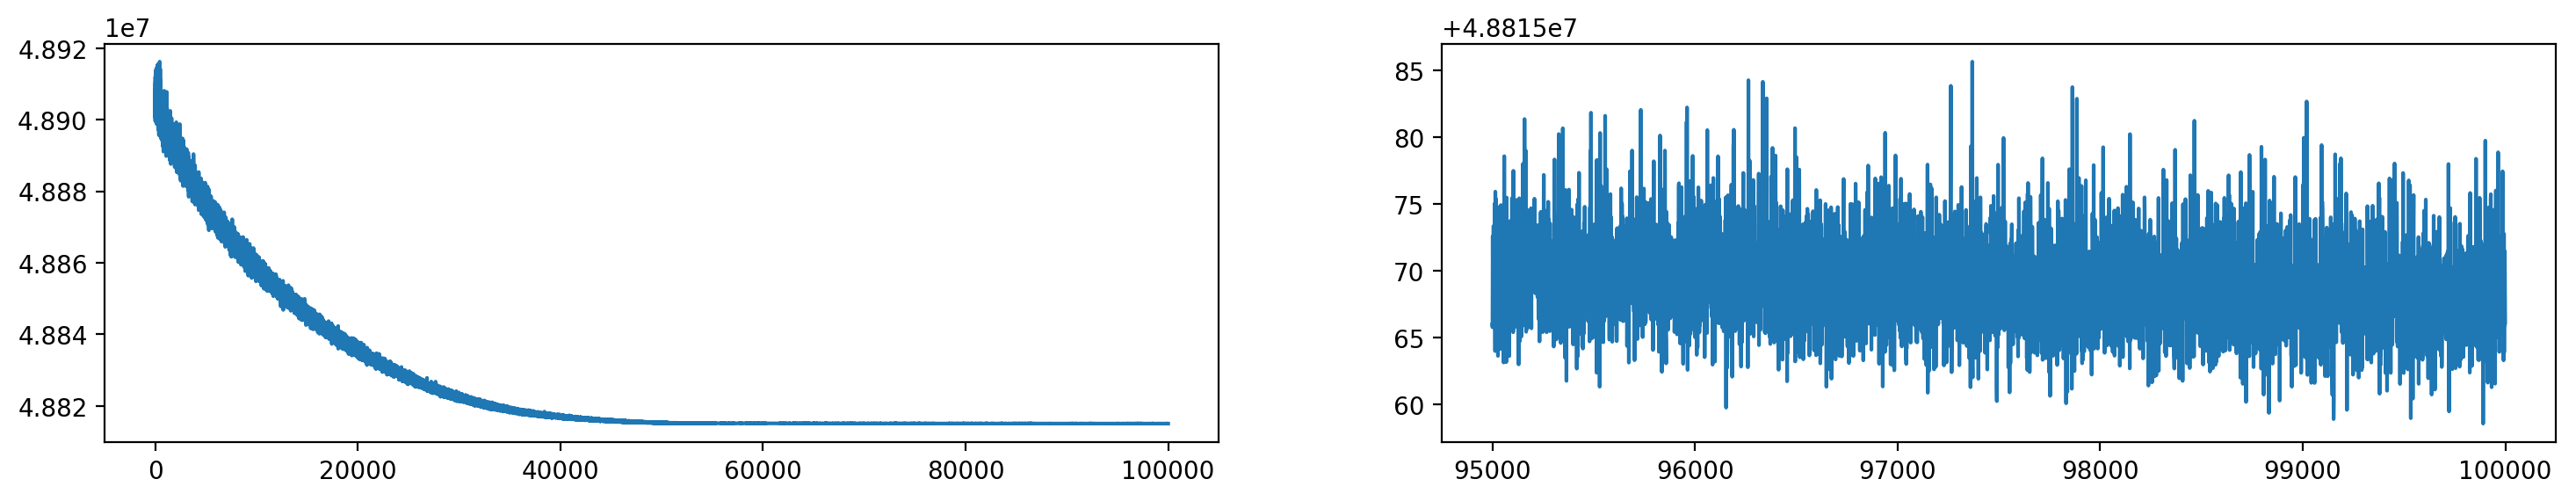

In [6]:
plt.figure(figsize=(18,3), dpi=200)
plt.subplot(1,2,1)
plt.plot(fit_me_b_gr.hist)

plt.subplot(1,2,2)
plt.plot(np.arange(95000,100000), fit_me_b_gr.hist[95000:])
plt.show()

It appears that it is mostly converged.

In [7]:
sample_me_b_gr = fit_me_b_gr.sample(2000)
pm.summary(sample_me_b_gr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu_all,269.681755,0.028404,0.000631,269.626257,269.737780
beta__0,-2.021269,0.147098,0.003653,-2.316908,-1.741562
beta__1,3.641030,0.128768,0.002628,3.369924,3.877422
beta__2,-10.508337,0.167912,0.003896,-10.851579,-10.192404
beta__3,-12.407181,0.120454,0.002379,-12.627628,-12.145293
beta__4,-8.318645,0.122606,0.002626,-8.566371,-8.091695
beta__5,-13.229769,0.135158,0.002752,-13.488876,-12.967521
beta__6,-13.064327,0.155806,0.003191,-13.359054,-12.752600
beta__7,-19.136183,0.133401,0.003349,-19.409184,-18.891591
beta__8,-4.103787,0.189458,0.004651,-4.480550,-3.729884


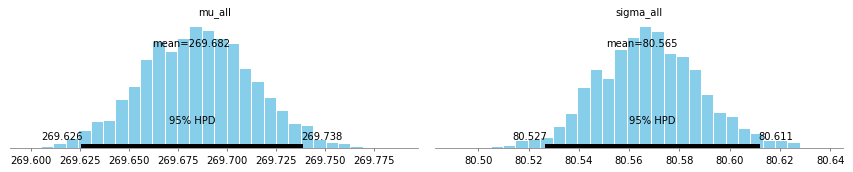

In [8]:
pm.plot_posterior(sample_me_b_gr, varnames=['mu_all', 'sigma_all'])
plt.show()

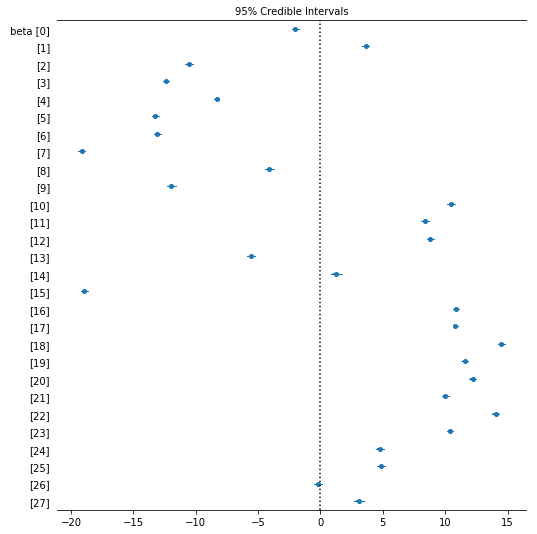

In [9]:
plt.figure(figsize=(8,8))
pm.forestplot(sample_me_b_gr, varnames=['beta'])
plt.show()

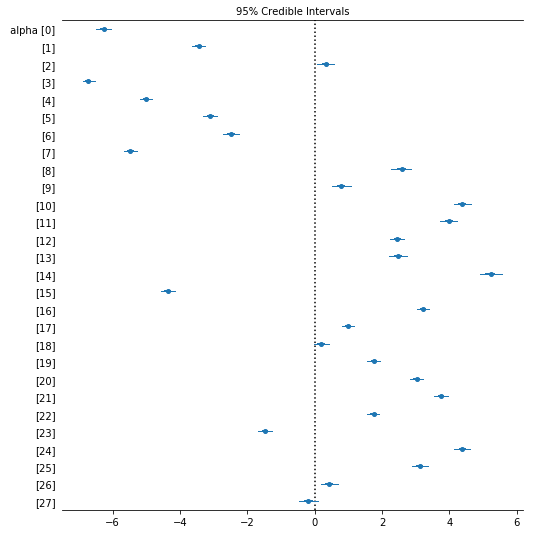

In [10]:
plt.figure(figsize=(8,8))
pm.forestplot(sample_me_b_gr, varnames=['alpha'])
plt.show()

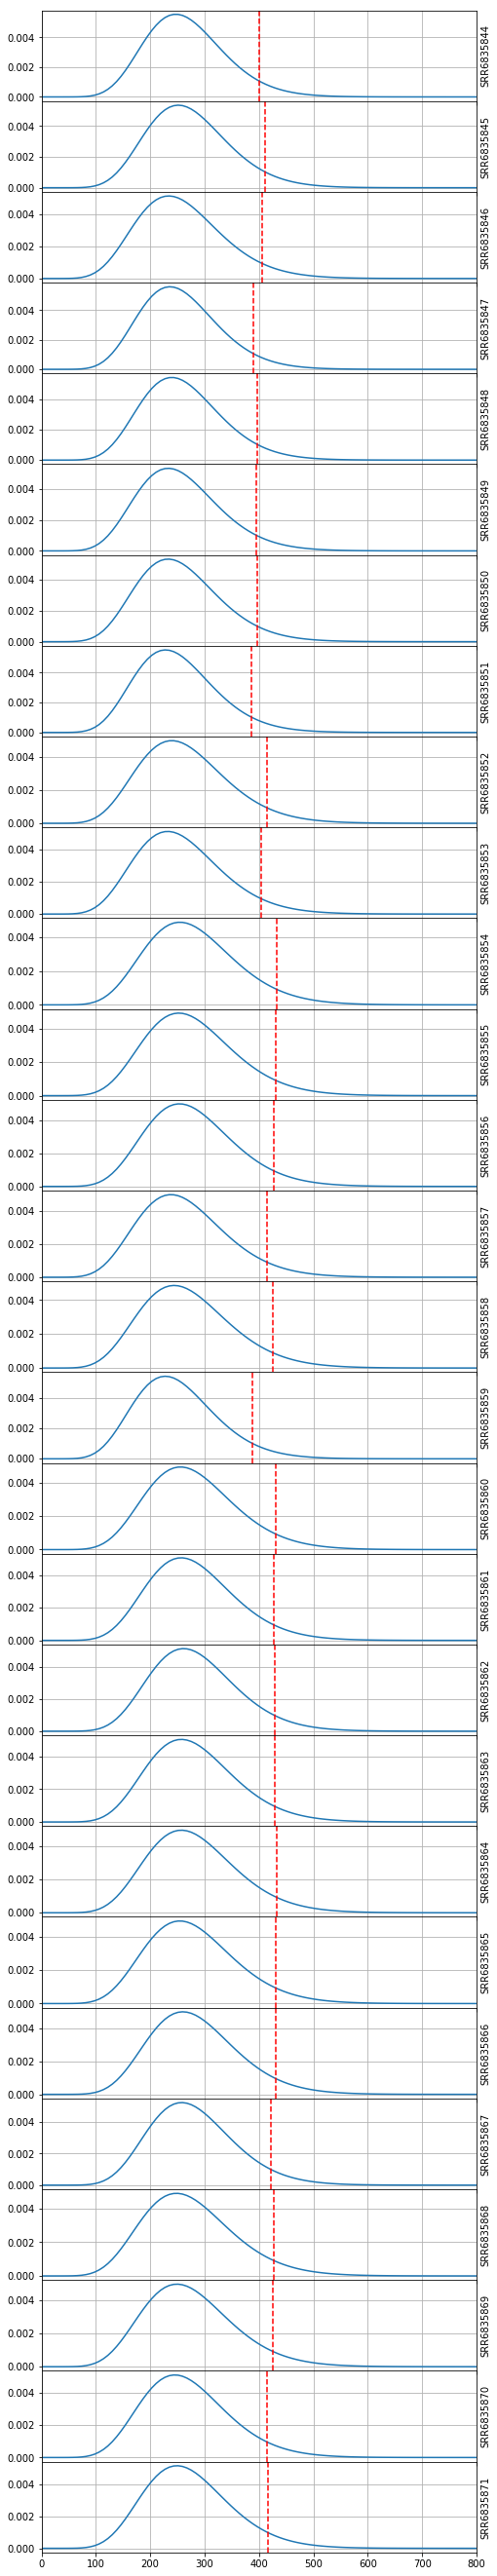

In [11]:
X_plt = np.linspace(1, 800, num=100)
mu_all_hat = np.mean(sample_me_b_gr['mu_all'])
sigma_all_hat = np.mean(sample_me_b_gr['sigma_all'])
beta_hat = np.mean(sample_me_b_gr['beta'], axis=0)
alpha_hat = np.mean(sample_me_b_gr['alpha'], axis=0)

f, axs = plt.subplots(B, sharex=True, figsize=(8,48))
f.subplots_adjust(hspace=0)
axs[0].set_xlim(left=0, right=800)

for i in range(B):
    a, scale = gamma_reparam(mu_all_hat + beta_hat[i], sigma_all_hat + alpha_hat[i])
    Y_plt = stats.gamma(a=a, scale=scale).pdf(x=X_plt)
    axs[i].plot(X_plt, Y_plt)
    axs[i].grid(True)
    axs[i].set(ylabel=batch_agg_coords[i])
    axs[i].yaxis.set_label_position("right")
    
    axs[i].axvline(x=stats.gamma(a=a, scale=scale).isf(0.05), color='r', linestyle='--')
    
plt.show()

## Aggregated Genes

In [17]:
with pm.Model() as mixed_effects_gene_gamma_regression:
    # mu prior, and coefficients
    mu_all = pm.Normal('mu_all', mu=270, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=G)

    # sigma prior, and coefficients
    sigma_all = pm.Normal('sigma_all', mu=80, sd=5)
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=G)
    
    # regression functions
    mu = mu_all + pm.math.dot(X_agg_g, beta)
    sigma = sigma_all + pm.math.dot(X_agg_g, alpha)
    
    y = pm.Potential('y_logp_weighted', W_agg_g*pm.Gamma.dist(mu=mu, sd=sigma).logp(Y_agg_g))
    
    vi_me_g_gr = pm.ADVI()
    
fit_me_g_gr = vi_me_g_gr.fit(n=100000, callbacks=[pm.callbacks.CheckParametersConvergence()])

Average Loss = 4.8851e+07: 100%|██████████| 100000/100000 [15:13<00:00, 109.47it/s]
Finished [100%]: Average Loss = 4.8851e+07


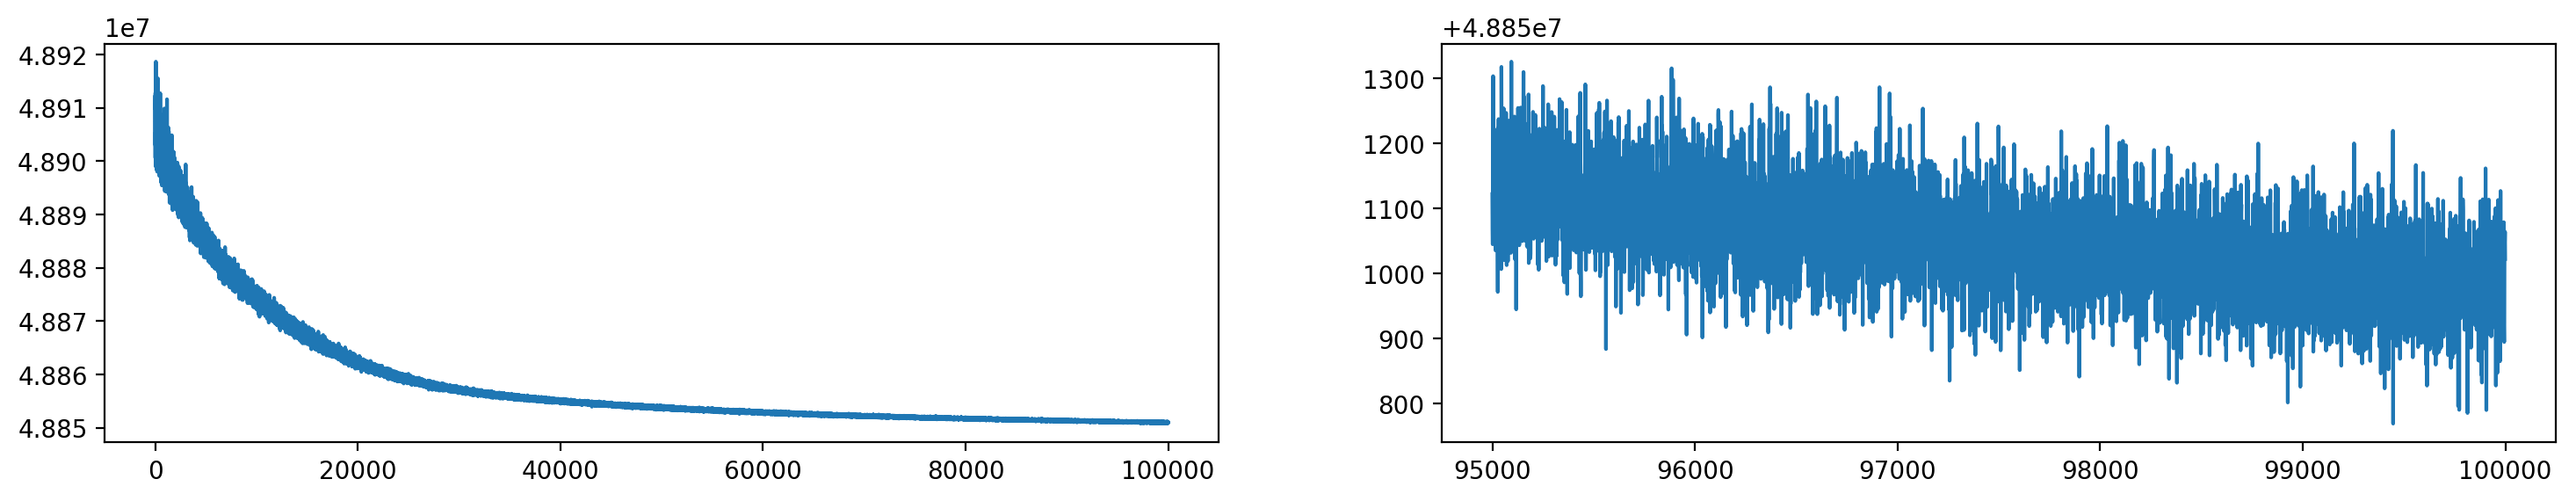

In [18]:
plt.figure(figsize=(18,3), dpi=200)
plt.subplot(1,2,1)
plt.plot(fit_me_g_gr.hist)

plt.subplot(1,2,2)
plt.plot(np.arange(95000,100000), fit_me_g_gr.hist[95000:])
plt.show()

In [19]:
fit_me_g_gr = vi_me_g_gr.fit(n=200000, callbacks=[pm.callbacks.CheckParametersConvergence()])

Average Loss = 4.885e+07: 100%|██████████| 200000/200000 [44:19<00:00, 70.97it/s]
Finished [100%]: Average Loss = 4.885e+07


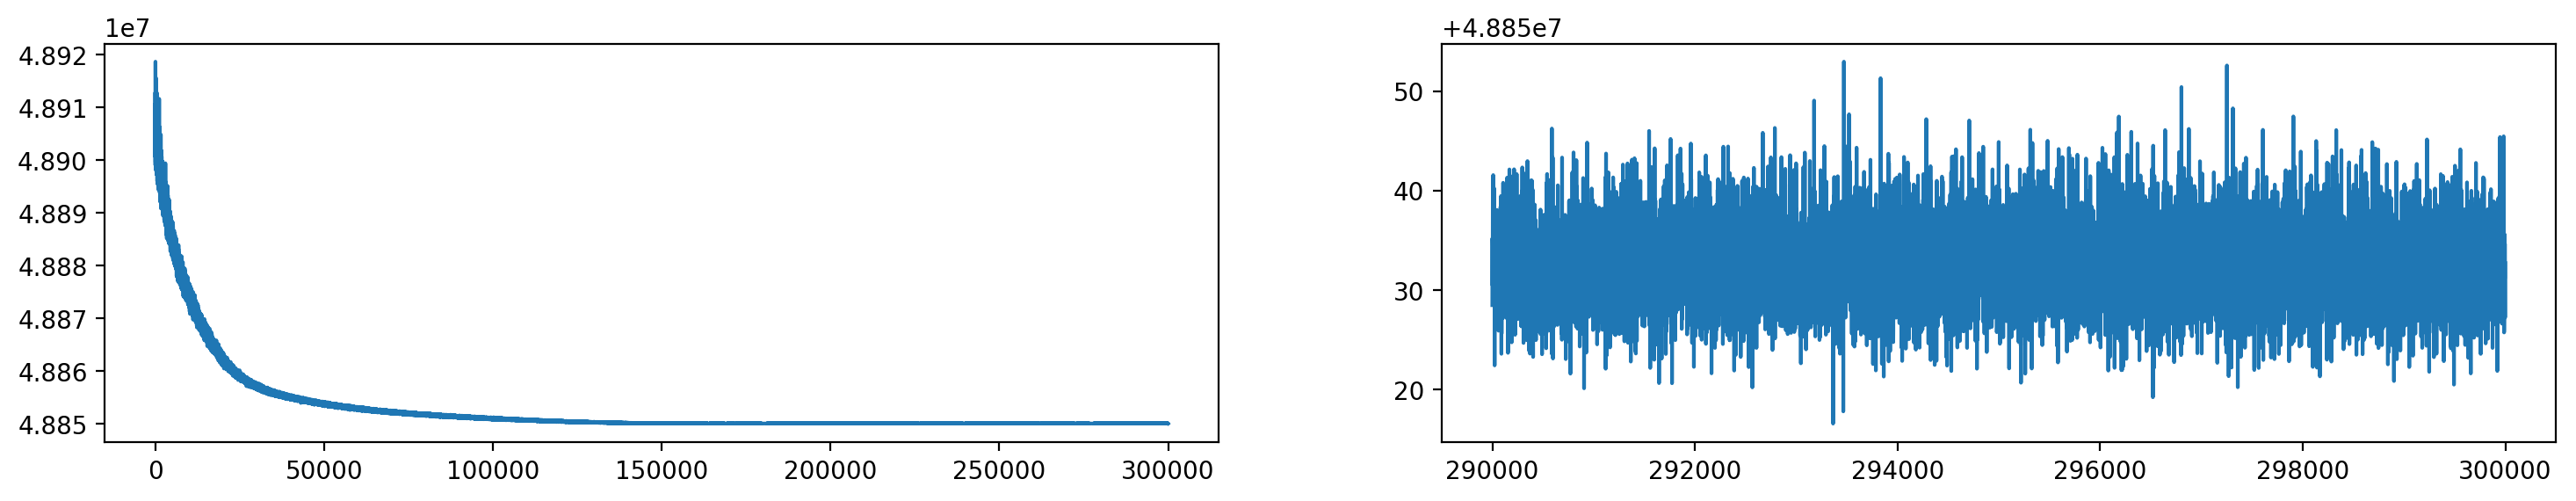

In [21]:
plt.figure(figsize=(18,3), dpi=200)
plt.subplot(1,2,1)
plt.plot(fit_me_g_gr.hist)

plt.subplot(1,2,2)
plt.plot(np.arange(290000,300000), fit_me_g_gr.hist[290000:])
plt.show()

In [23]:
sample_me_g_gr = fit_me_g_gr.sample(2000)
pm.summary(sample_me_g_gr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu_all,273.033440,0.027930,0.000661,272.977646,273.084391
beta__0,1.703695,0.372505,0.007983,0.880083,2.340325
beta__1,-11.765632,0.105406,0.002389,-11.971523,-11.558881
beta__2,-1.486862,0.348638,0.008161,-2.144283,-0.789124
beta__3,2.753647,0.345204,0.007924,2.084077,3.436843
beta__4,-3.200272,0.223554,0.005326,-3.636458,-2.754311
beta__5,-4.487886,0.397692,0.008913,-5.334269,-3.757109
beta__6,-8.819162,0.110113,0.002546,-9.020893,-8.594648
beta__7,0.731344,0.695996,0.014021,-0.547768,2.141847
beta__8,2.746074,0.149517,0.003258,2.455017,3.031749


In [24]:
traz_me_g_gr = az.from_pymc3(trace=sample_me_g_gr,
                             coords={'gene': gene_agg_coords},
                             dims={'beta': ['gene'], 'alpha': ['gene']})

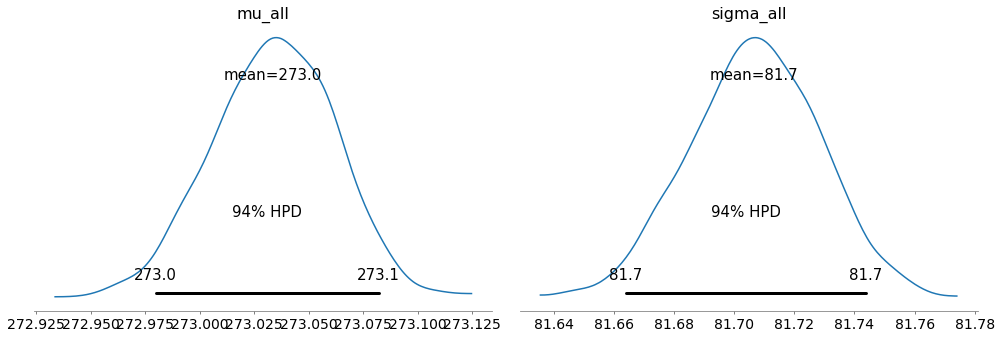

In [25]:
az.plot_posterior(traz_me_g_gr, var_names=['mu_all', 'sigma_all'])
plt.show()

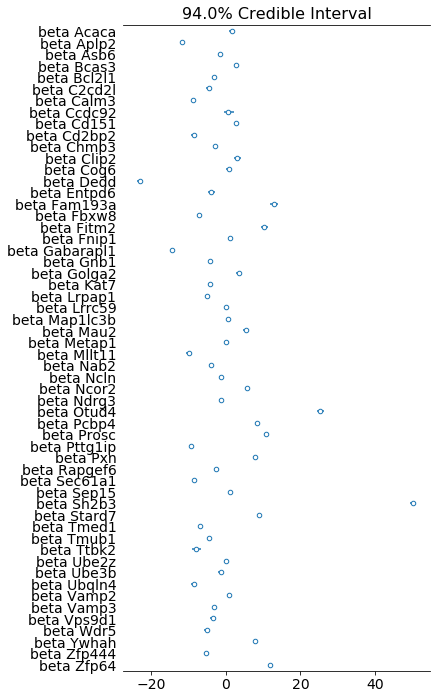

In [26]:
az.plot_forest(traz_me_g_gr, var_names=['beta'])
plt.show()

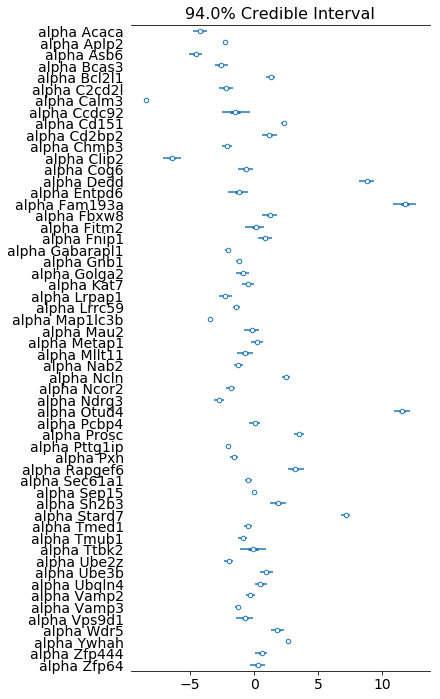

In [27]:
az.plot_forest(traz_me_g_gr, var_names=['alpha'])
plt.show()

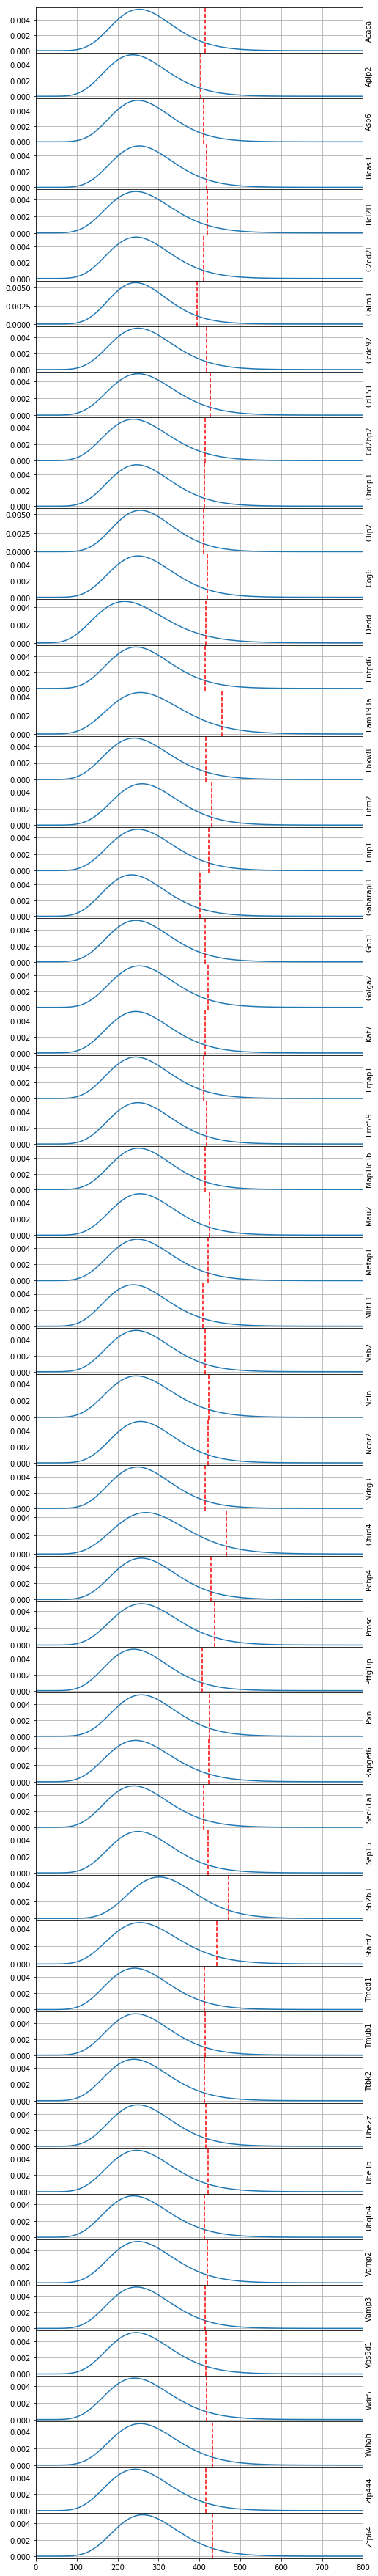

In [29]:
X_plt = np.linspace(1, 800, num=100)
mu_all_hat = np.mean(sample_me_g_gr['mu_all'])
sigma_all_hat = np.mean(sample_me_g_gr['sigma_all'])
beta_hat = np.mean(sample_me_g_gr['beta'], axis=0)
alpha_hat = np.mean(sample_me_g_gr['alpha'], axis=0)

f, axs = plt.subplots(G, sharex=True, figsize=(8,64))
f.subplots_adjust(hspace=0)
axs[0].set_xlim(left=0, right=800)

for i in range(G):
    a, scale = gamma_reparam(mu_all_hat + beta_hat[i], sigma_all_hat + alpha_hat[i])
    Y_plt = stats.gamma(a=a, scale=scale).pdf(x=X_plt)
    axs[i].plot(X_plt, Y_plt)
    axs[i].grid(True)
    axs[i].set(ylabel=gene_agg_coords[i])
    axs[i].yaxis.set_label_position("right")
    
    axs[i].axvline(x=stats.gamma(a=a, scale=scale).isf(0.05), color='r', linestyle='--')
    
plt.show()

## Full Model

In [26]:
# Minibatches
X_mb = pm.Minibatch(X, batch_size=10000, random_seed=42)
W_mb = pm.Minibatch(W, batch_size=10000, random_seed=42)
Y_mb = pm.Minibatch(Y, batch_size=10000, random_seed=42)
tot_size = len(Y)

/Users/mfansler/miniconda3/envs/pymc36/lib/python3.7/site-packages/pymc3/data.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/Users/mfansler/miniconda3/envs/pymc36/lib/python3.7/site-packages/pymc3/data.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [43]:
with pm.Model() as mixed_effects_full_gamma_regression:
    # mu prior, and coefficients
    mu_all = pm.Normal('mu_all', mu=270, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=B+G)

    # sigma prior, and coefficients
    sigma_all = pm.Normal('sigma_all', mu=80, sd=5)
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=B+G)
    
    # regression functions
    mu = mu_all + pm.math.dot(X_mb, beta)
    sigma = sigma_all + pm.math.dot(X_mb, alpha)
    
    def weighted_gamma_logp(y, w):
        return w*pm.Gamma.dist(mu=mu, sd=sigma).logp(y)
    
    y = pm.DensityDist('y_logp_weighted', weighted_gamma_logp, observed={'y': Y_mb, 'w':W_mb}, total_size=Y.shape[0])
    #y = pm.Potential('y_logp_weighted', W_mb*pm.Gamma.dist(mu=mu, sd=sigma).logp(Y_mb))
    
    vi_me_gr = pm.FullRankADVI()
    
fit_me_gr = vi_me_gr.fit(n=100000, callbacks=[pm.callbacks.CheckParametersConvergence()])

MissingInputError: Input 1 of the graph (indices start from 0), used to compute dot(Minibatch, alpha), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

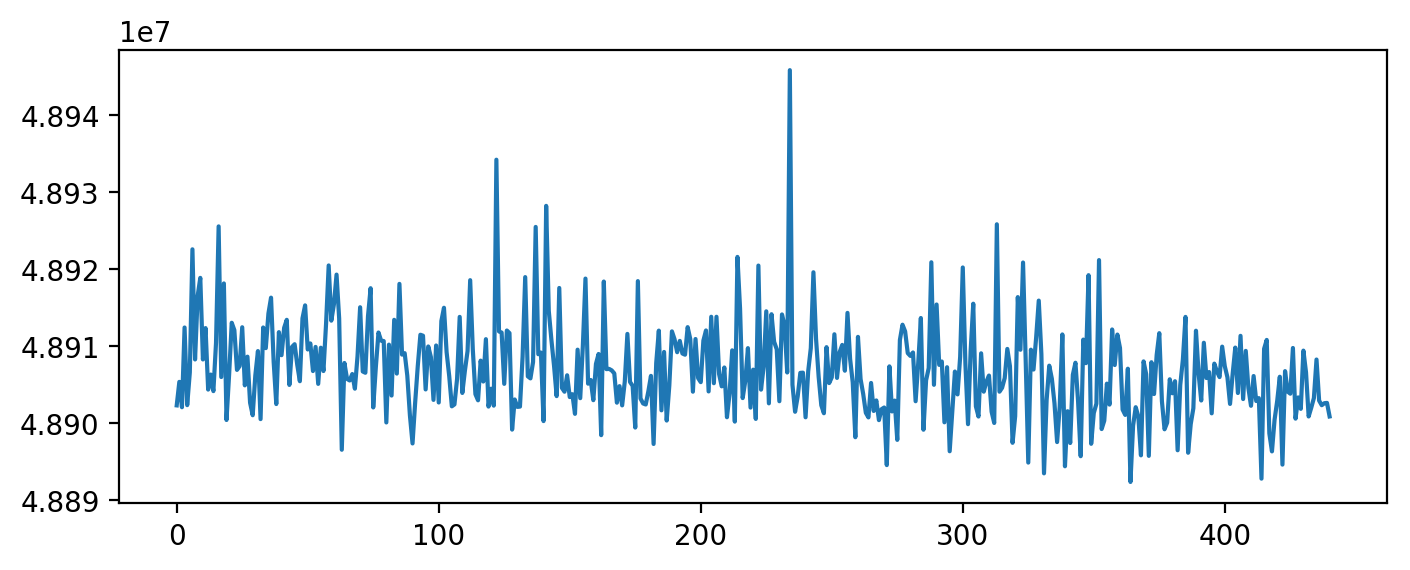

In [39]:
plt.figure(figsize=(18,3), dpi=200)
plt.subplot(1,2,1)
plt.plot(fit_me_gr.hist)

#plt.subplot(1,2,2)
#plt.plot(np.arange(99000,100000), fit_me_gr.hist[99000:])
plt.show()

In [40]:
sample_me_gr = fit_me_gr.sample(2000)
pm.summary(sample_me_gr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu_all,270.080063,0.942487,0.019835,268.319938,271.920048
beta__0,0.117056,0.994957,0.022049,-1.899359,2.057280
beta__1,-0.144884,0.977690,0.023754,-2.151098,1.610954
beta__2,0.126850,0.945489,0.020742,-1.649003,1.941472
beta__3,0.124036,1.002735,0.020885,-1.799138,2.103386
beta__4,-0.092535,0.960358,0.022879,-1.977874,1.781056
beta__5,-0.093236,0.950015,0.019303,-2.005343,1.619133
beta__6,-0.165680,0.975104,0.022647,-1.960976,1.823093
beta__7,0.141348,0.973301,0.021291,-1.823519,2.027503
beta__8,0.135515,0.987682,0.023924,-1.662232,2.229819


In [41]:
traz_me_gr = az.from_pymc3(trace=sample_me_gr,
                           coords={'batch-gene': batch_coords + gene_coords},
                           dims={'beta': ['batch-gene'], 'alpha': ['batch-gene']})

/Users/mfansler/miniconda3/envs/pymc36/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


KeyboardInterrupt: 

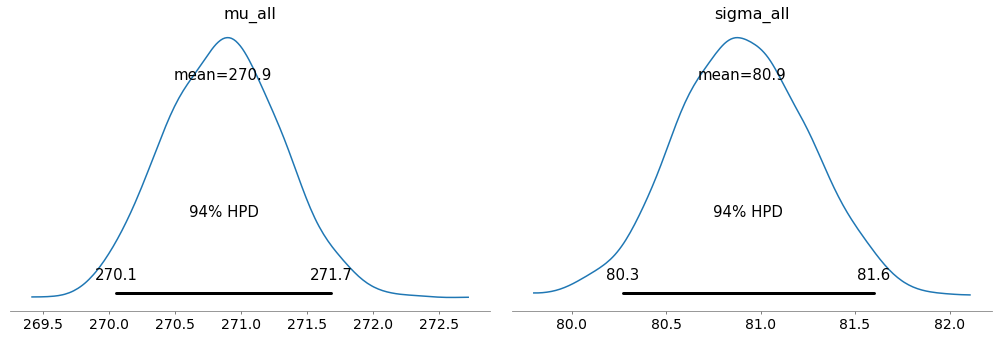

In [36]:
az.plot_posterior(traz_me_gr, var_names=['mu_all', 'sigma_all'])
plt.show()

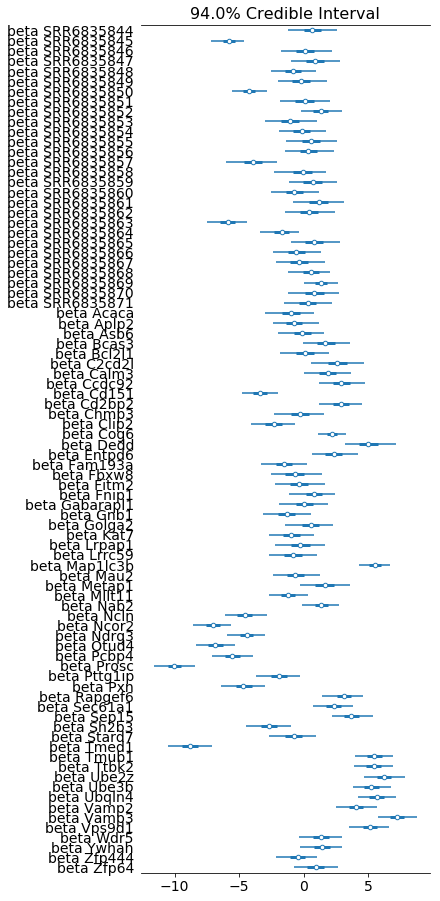

In [37]:
az.plot_forest(traz_me_gr, var_names=['beta'])
plt.show()

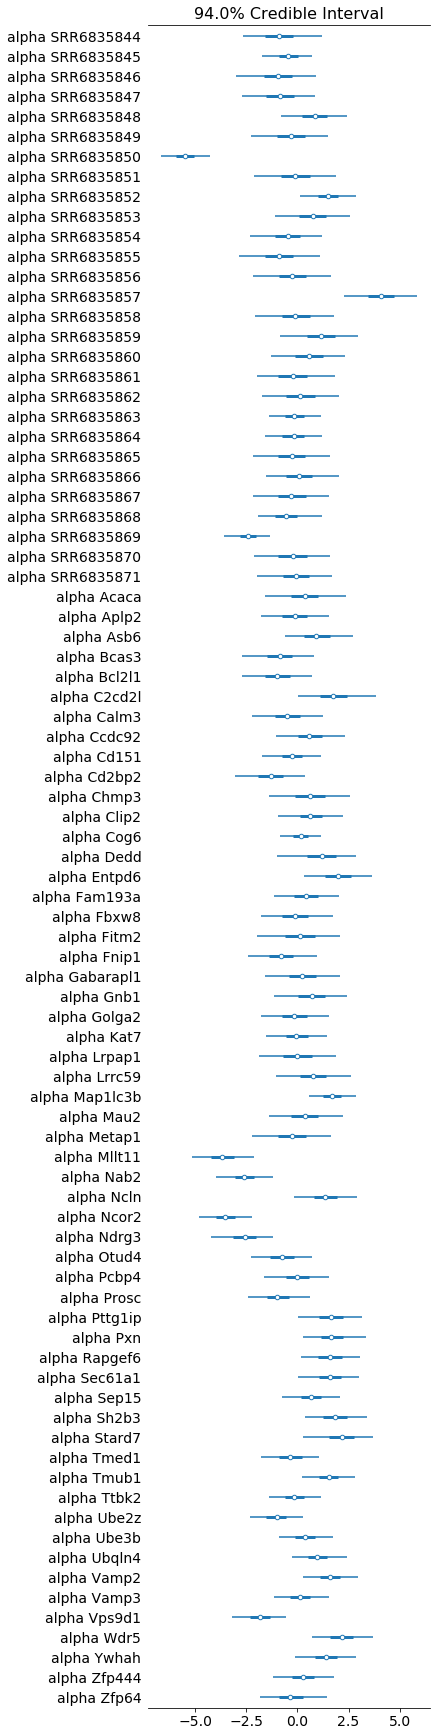

In [40]:
az.plot_forest(traz_me_gr, var_names=['alpha'], figsize=(6,24))
plt.show()

In [41]:
mu_all_hat = np.mean(sample_me_gr['mu_all'])
sigma_all_hat = np.mean(sample_me_gr['sigma_all'])
beta_hat = np.mean(sample_me_gr['beta'], axis=0)
alpha_hat = np.mean(sample_me_gr['alpha'], axis=0)

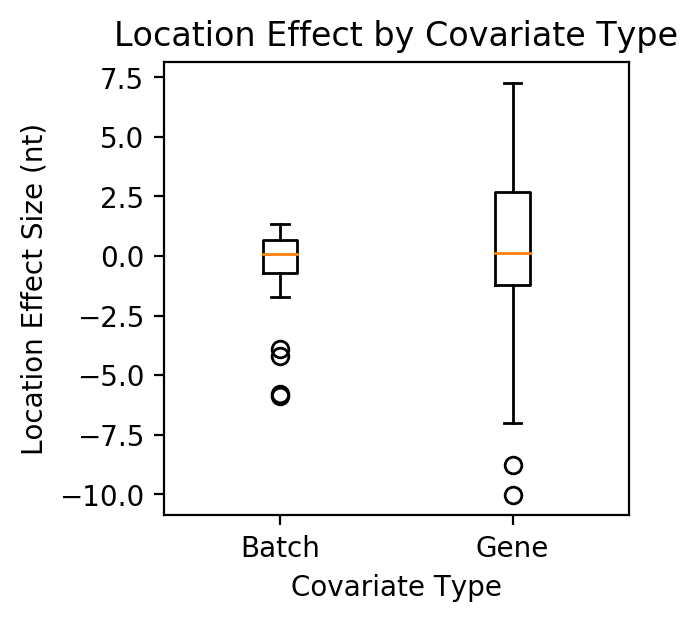

In [59]:
plt.figure(figsize=(3,3), dpi=200)
plt.boxplot([beta_hat[:B], beta_hat[B:]], labels=['Batch', 'Gene'])
plt.title("Location Effect by Covariate Type")
plt.xlabel("Covariate Type")
plt.ylabel("Location Effect Size (nt)")
plt.show()

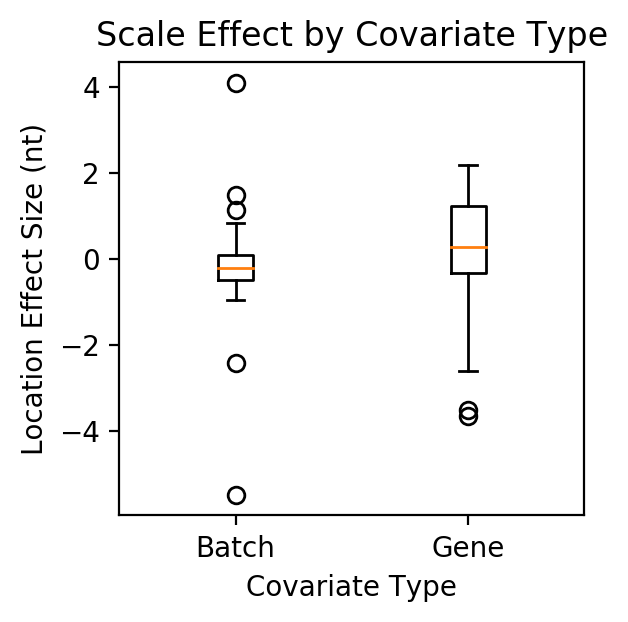

In [58]:
plt.figure(figsize=(3,3), dpi=200)
plt.boxplot([alpha_hat[:B], alpha_hat[B:]], labels=['Batch', 'Gene'])
plt.title("Scale Effect by Covariate Type")
plt.xlabel("Covariate Type")
plt.ylabel("Location Effect Size (nt)")
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.boxplot([alpha_hat[:B], alpha_hat[B:]], labels=['Batch', 'Gene'])
plt.title("Scale Effect by Covariate Type")
plt.xlabel("Covariate Type")
plt.ylabel("Location Effect Size (nt)")
plt.show()

In [45]:
cutoff_95 = np.empty((B, G))

a_all = sigma_all_hat
b_all = mu_all_hat

for i in range(B):
    a_i, b_i = alpha_hat[i], beta_hat[i]
    
    for j in range(G):
        a_j, b_j = alpha_hat[B + j], beta_hat[B + j]
        a, scale = gamma_reparam(b_all + b_i + b_j, a_all + a_i + a_j)
        
        cutoff_95[i, j] = stats.gamma(a=a, scale=scale).isf(0.05)

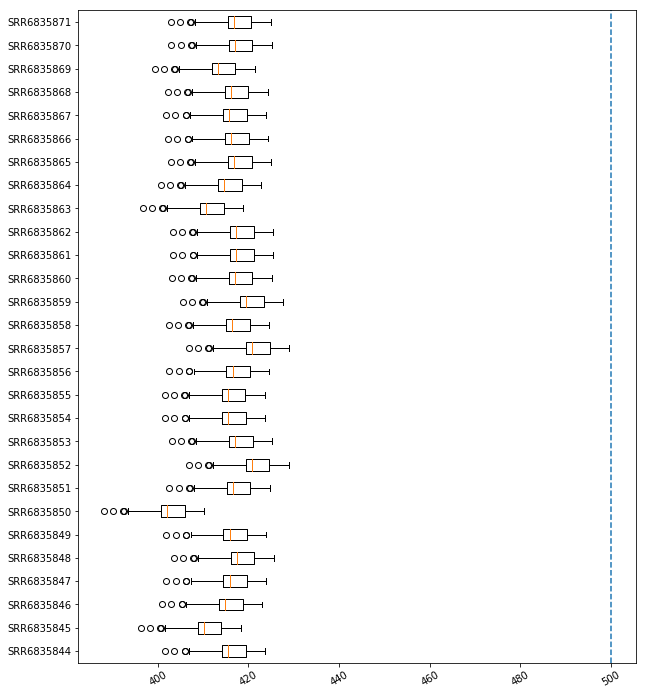

In [46]:
plt.figure(figsize=(10,12))
plt.boxplot(cutoff_95.T, labels=batch_coords, vert=False)
plt.xticks(rotation=30)
plt.axvline(500, linestyle='--')

plt.show()

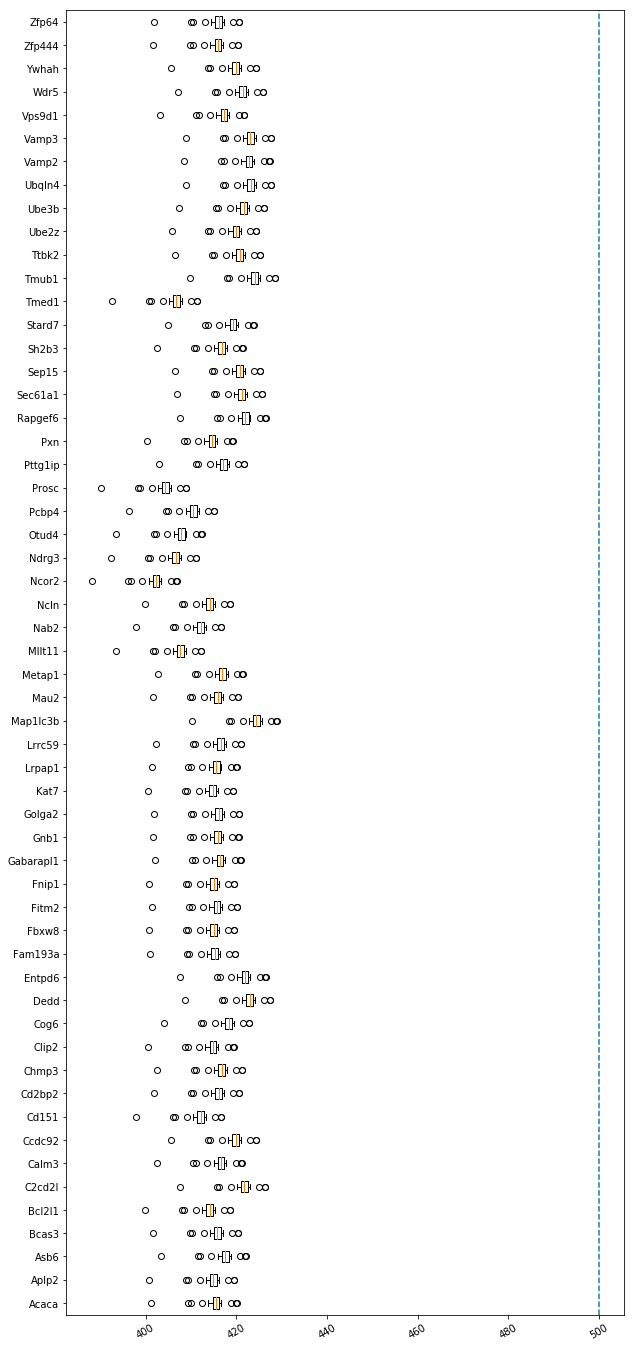

In [47]:
plt.figure(figsize=(10,24))
plt.boxplot(cutoff_95, labels=gene_coords, vert=False)
plt.xticks(rotation=30)
plt.axvline(500, linestyle='--')

plt.show()

# Full Model - MAP Fit

In [61]:
with pm.Model() as mixed_effects_full_gamma_regression_map:
    # mu prior, and coefficients
    mu_all = pm.Normal('mu_all', mu=270, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=B+G)

    # sigma prior, and coefficients
    sigma_all = pm.Normal('sigma_all', mu=80, sd=5)
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=B+G)
    
    # regression functions
    mu = mu_all + pm.math.dot(X, beta)
    sigma = sigma_all + pm.math.dot(X, alpha)
    
    y = pm.Potential('y_logp_weighted', W*pm.Gamma.dist(mu=mu, sd=sigma).logp(Y))
    
    map_me_gr = pm.find_MAP()


/Users/mfansler/miniconda3/envs/pymc36/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -4.8772e+07, ||grad|| = 18.056: 100%|██████████| 68/68 [01:19<00:00,  1.16s/it]     


In [62]:
for k, v in map_me_gr.items():
    print("%s: %s | mean = %f | median = %f" % (k, v.shape, np.mean(v), np.median(v)))

mu_all: () | mean = 272.031022 | median = 272.031022
beta: (84,) | mean = 0.018691 | median = -0.694789
sigma_all: () | mean = 81.060341 | median = 81.060341
alpha: (84,) | mean = 0.008896 | median = -0.067533


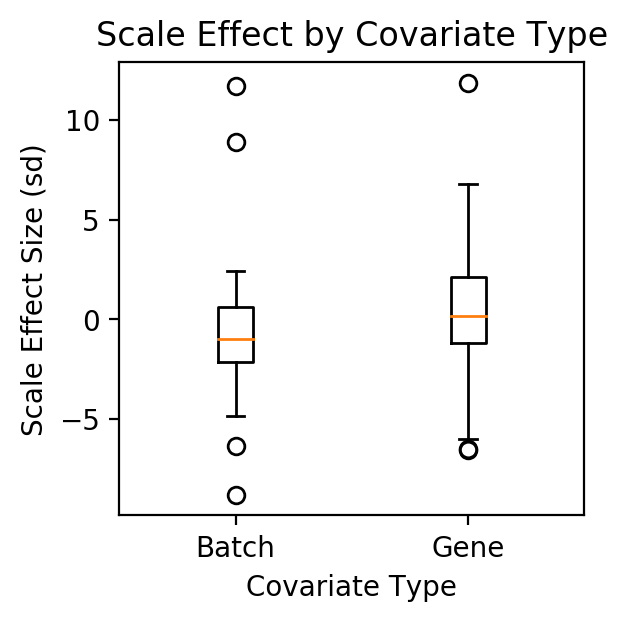

In [64]:
plt.figure(figsize=(3,3), dpi=200)
plt.boxplot([map_me_gr['alpha'][:B], map_me_gr['alpha'][B:]], labels=['Batch', 'Gene'])
plt.title("Scale Effect by Covariate Type")
plt.xlabel("Covariate Type")
plt.ylabel("Scale Effect Size (sd)")
plt.show()

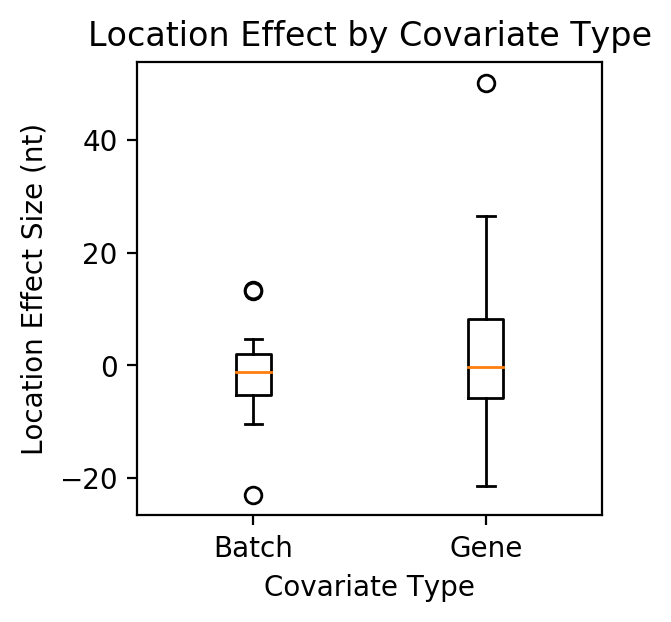

In [65]:
plt.figure(figsize=(3,3), dpi=200)
plt.boxplot([map_me_gr['beta'][:B], map_me_gr['beta'][B:]], labels=['Batch', 'Gene'])
plt.title("Location Effect by Covariate Type")
plt.xlabel("Covariate Type")
plt.ylabel("Location Effect Size (nt)")
plt.show()

In [66]:
cutoff_95 = np.empty((B, G))

a_all = map_me_gr['sigma_all']
b_all = map_me_gr['mu_all']

for i in range(B):
    a_i, b_i = map_me_gr['alpha'][i], map_me_gr['beta'][i]
    
    for j in range(G):
        a_j, b_j = map_me_gr['alpha'][B + j], map_me_gr['beta'][B + j]
        a, scale = gamma_reparam(b_all + b_i + b_j, a_all + a_i + a_j)
        
        cutoff_95[i, j] = stats.gamma(a=a, scale=scale).isf(0.05)

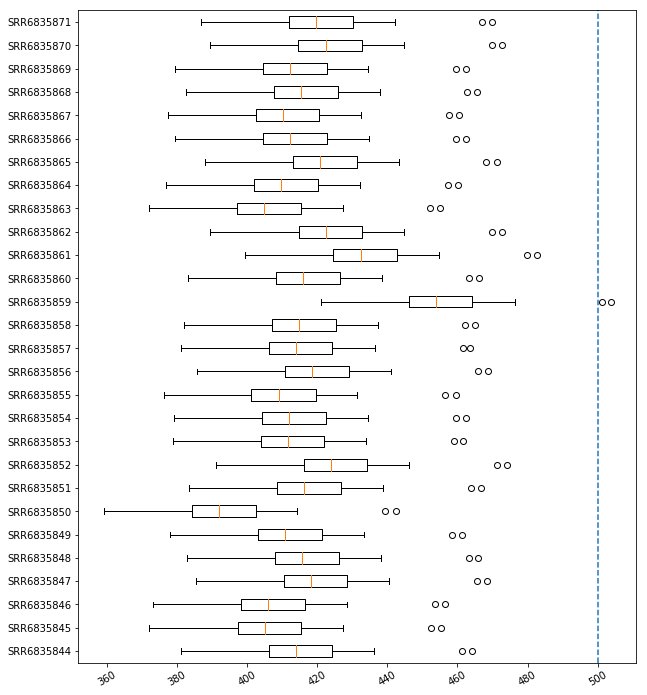

In [67]:
plt.figure(figsize=(10,12))
plt.boxplot(cutoff_95.T, labels=batch_coords, vert=False)
plt.xticks(rotation=30)
plt.axvline(500, linestyle='--')

plt.show()

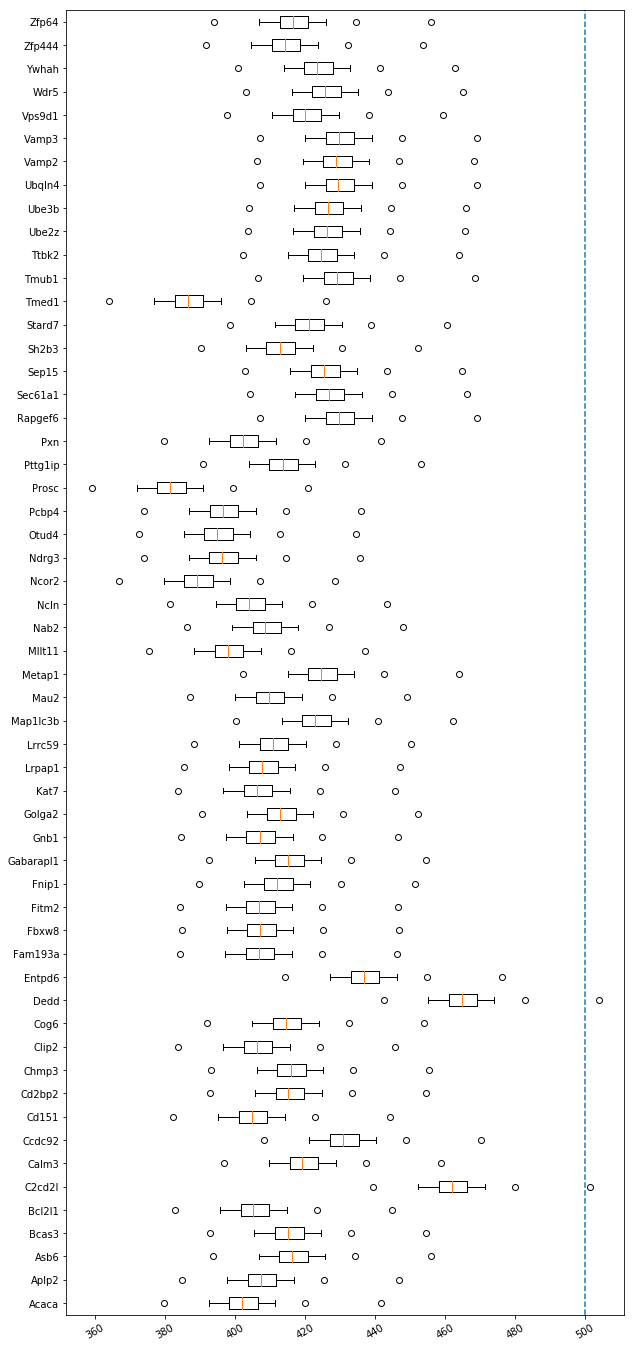

In [68]:
plt.figure(figsize=(10,24))
plt.boxplot(cutoff_95, labels=gene_coords, vert=False)
plt.xticks(rotation=30)
plt.axvline(500, linestyle='--')

plt.show()

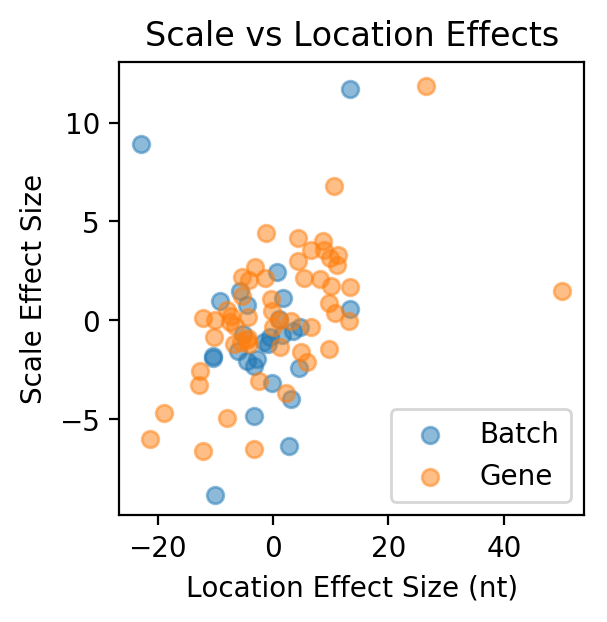

In [75]:
plt.figure(figsize=(3,3), dpi=200)
plt.scatter(map_me_gr['beta'][:B], map_me_gr['alpha'][:B], alpha=0.5)
plt.scatter(map_me_gr['beta'][B:], map_me_gr['alpha'][B:], alpha=0.5)
plt.title("Scale vs Location Effects")
plt.ylabel("Scale Effect Size")
plt.xlabel("Location Effect Size (nt)")
plt.legend(['Batch', 'Gene'])
plt.show()

## Save Data

In [80]:
import pickle

In [83]:
# aggregated batch model
az.save_data(traz_me_b_gr, "results/arviz.mixed.batch.gammareg.vi.netcdf")
az.save_data(traz_me_g_gr, "results/arviz.mixed.gene.gammareg.vi.netcdf")
az.save_data(traz_me_gr, "results/arviz.mixed.full.gammareg.vi.netcdf")
with open("results/mixed.full.gammareg.map.pkl", 'wb') as f:
    pickle.dump(map_me_gr, f)